Self Distillation test

In [2]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.

import branching

from branching import branches
from branching import evaluate

# branching.enable_neptune(False)


In [3]:
train_ds, test_ds, validation_ds = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [4]:
train_ds100, test_ds100, validation_ds100 = branching.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


### Define the Branch Model. this is a subclass of the standard Keras model and can do all the normal things

In [5]:
class BranchModel(tf.keras.Model):
    '''
    Branched model sub-class. 
    Acts as a drop in replacement keras model class, with the additional functionality of adding branches to the model.
            
    '''
    def __init__(self, inputs=None, outputs=None, name="", model=None, transfer=True,custom_objects={}):
        ## add default custom objects to the custom objects dictionary, this saves having to define them everytime.
        custom_objects = {**branching.default_custom_objects,**custom_objects} 
        if inputs  is None and model is None and name is not "":
            model = tf.keras.models.load_model(name,custom_objects=custom_objects)
            self.saveLocation = name
            super(BranchModel, self).__init__(inputs = model.inputs, outputs=model.outputs,name=model.name)            
        elif model is None:
            super(BranchModel, self).__init__(inputs = inputs, outputs=outputs,name=name)
        elif model is not None:
            super(BranchModel, self).__init__(inputs = model.inputs, outputs=model.outputs,name=name)
        self.transfer = transfer
        self.custom_objects = custom_objects
        ##remap the depths of the layers to match the desired layout for branching
        # self._map_graph_network(self.inputs,self.outputs, True)
        self.branch_active = False
   
    def _run_internal_graph(self, inputs, training=None, mask=None):
        """custom version of _run_internal_graph
            used to allow for interuption of the graph by an internal layer if conditions are met.
        Computes output tensors for new inputs.
        Args:
            inputs: Tensor or nested structure of Tensors.
            training: Boolean learning phase.
            mask: (Optional) Tensor or nested structure of Tensors.

        Returns:
            output_tensors
        """
        inputs = self._flatten_to_reference_inputs(inputs)
        if mask is None:
            masks = [None] * len(inputs)
        else:
            masks = self._flatten_to_reference_inputs(mask)
        for input_t, mask in zip(inputs, masks):
            input_t._keras_mask = mask

        # Dictionary mapping reference tensors to computed tensors.
        tensor_dict = {}
        tensor_usage_count = self._tensor_usage_count
        for x, y in zip(self.inputs, inputs):
            y = self._conform_to_reference_input(y, ref_input=x)
            x_id = str(id(x))
            tensor_dict[x_id] = [y] * tensor_usage_count[x_id]

        nodes_by_depth = self._nodes_by_depth
        depth_keys = list(nodes_by_depth.keys())
        depth_keys.sort(reverse=True)
    
        for depth in depth_keys:
            nodes = nodes_by_depth[depth]
            for node in nodes:
                # print(node.layer.name)
                if node.is_input:
                    continue  # Input tensors already exist.

                if any(t_id not in tensor_dict for t_id in node.flat_input_ids):
                    continue  # Node is not computable, try skipping.

                args, kwargs = node.map_arguments(tensor_dict)
                outputs = node.layer(*args, **kwargs)
                # Update tensor_dict.
                for x_id, y in zip(node.flat_output_ids, nest.flatten(outputs)):
                    tensor_dict[x_id] = [y] * tensor_usage_count[x_id]
                
                ## check if branch exiting is turned on and if current layer is a potential exit.
                # print(node.layer.name, hasattr(node.layer, 'branch_exit'))
                if not training:
                    if self.branch_active == True and hasattr(node.layer, 'branch_exit'):  
                        ## check if the confidence of output of the layer is equal to or above the threshold hyperparameter
                        # print("threshold: ", node.layer.threshold, "evidence: ", tf.reduce_sum(node.layer.evidence(outputs)))
                        if node.layer.branch_exit and (tf.reduce_sum(node.layer.evidence(outputs)) >= node.layer.confidence_threshold): ##check if current layer's exit is active
                            # print("branch exit activated")
                            output_tensors = []
                            for x_id, y in zip(node.flat_output_ids, nest.flatten(outputs)):
                                for x in self.outputs:
                                    output_id = str(id(x))  
                                    if output_id == x_id:
                                        output_tensors.append(tensor_dict[x_id])
                                    else:
                                        # print(tensor_dict[x_id][0].shape)
                                        output_tensors.append(tf.zeros(tensor_dict[x_id][0].shape))
                                    # x_id_output = str(id(x))
                                    # assert x_id in tensor_dict, 'Could not compute output ' + str(x)
                                    # output_tensors.append(tensor_dict[x_id])

                            return nest.pack_sequence_as(self._nested_outputs, output_tensors)
        output_tensors = []
        for x in self.outputs:
            x_id = str(id(x))
            assert x_id in tensor_dict, 'Could not compute output ' + str(x)
            output_tensors.append(tensor_dict[x_id].pop())

        return nest.pack_sequence_as(self._nested_outputs, output_tensors)

    def add_branches(self,branchName, branchPoints=[], exact = True, target_input = False, compact = False, loop=True,num_outputs=10):
        if len(branchPoints) == 0:
            return
        # ["max_pooling2d","max_pooling2d_1","dense"]
        # branch.newBranch_flatten
        if loop:
            newModel = branch.add_loop(self,branchName, branchPoints,exact=exact, target_input = target_input, compact = compact,num_outputs=num_outputs)
        else:
            newModel = branch.add(self,branchName,branchPoints, exact=exact, target_input = target_input, compact = compact,num_outputs=num_outputs)
        print("branch added", newModel)
        self.__dict__.update(newModel.__dict__)

        return self

#     def compile(self, loss, optimizer, metrics=['accuracy'], run_eagerly=True, preset="",**kwargs):
#         ''' compile the model with custom options, either ones provided here or ones already set'''

#         # if preset == "":
#             # preset = self.customOptions
#         print(preset)
#         if preset == "customLoss": 
#             print("preset: customLoss")
#             loss_fn = evidence_crossentropy()
#             super().compile(loss=loss_fn, optimizer=tf.optimizers.SGD(learning_rate=0.001,momentum=0.9), metrics=['accuracy'],run_eagerly=True,**kwargs)
#         elif preset == "customLoss_onehot": 
#             print("preset: CrossE_onehot")
#             super().compile( loss={"dense_2":keras.losses.CategoricalCrossentropy(from_logits=True)}, optimizer=tf.optimizers.SGD(learning_rate=0.01,momentum=0.9), metrics=['accuracy'],run_eagerly=True,**kwargs)

#         elif preset == "CrossE": 
#             print("preset: CrossE")
#             super().compile( loss =tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.optimizers.SGD(learning_rate=0.01,momentum=0.9), metrics=['accuracy'],run_eagerly=True,**kwargs)

#         elif preset == "CrossE_Eadd":
#             print("preset: CrossE_Eadd")
#             entropyAdd = entropyAddition_loss()
#             super().compile( optimizer=tf.optimizers.SGD(learning_rate=0.01,momentum=0.9,clipvalue=0.5), loss=[keras.losses.SparseCategoricalCrossentropy(),entropyAdd,entropyAdd,entropyAdd], metrics=['accuracy',confidenceScore, unconfidence],run_eagerly=True,**kwargs)
#             # model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001), loss=[crossE_test, entropyAdd, entropyAdd, entropyAdd], metrics=['accuracy',confidenceScore, unconfidence],run_eagerly=True)
#         else:
#             print("preset: Other")
#         # model.compile(loss=entropyAddition, optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'],run_eagerly=True)
#             super().compile(loss=loss, optimizer=optimizer, metrics=['accuracy'], **kwargs)

    def setTrainable(self,trainable):
        """ sets the trainable status of all main path layers in the model"""
        if trainable == True: 
            print("Freezing Main Layers and setting branch layers training to true")
            for i in range(len(self.layers)):
                # print(model.layers[i].name)
                if "branch" in self.layers[i].name:
                    # print("setting ",self.layers[i].name," training to true")
                    self.layers[i].trainable = True
                else: 
                    # print("setting ",self.layers[i].name," training to false")
                    self.layers[i].trainable = False               
        else:
            print("Setting Main Layers  and branch layers training to true")
            for i in range(len(self.layers)):
                # print(model.layers[i].name)
                self.layers[i].trainable = True
                # print("setting ",self.layers[i].name," training to true")


    def fit(self, train_ds, validation_data=None, epochs=1, callbacks=[], saveName = "", transfer = False, customOptions=""):
        """Train the model that is passed using transfer learning. This function expects a model with trained main branches and untrained (or randomized) side branches.
    """
        logs = []
        num_outputs = len(self.outputs) # the number of output layers for the purpose of providing labels
        #Freeze main branch layers
        #how to iterate through layers and find main branch ones?
        #simple fix for now: all branch nodes get branch in name.
        self.setTrainable(transfer)
        run_logdir = get_run_logdir(self.name)
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
        if saveName =="":
            newModelName = "{}_branched".format(self.name )
        else:
            newModelName = saveName
        checkpoint = keras.callbacks.ModelCheckpoint("models/{}".format(newModelName), monitor='val_loss', verbose=1, mode='max')

        history =super().fit(train_ds,
                epochs=epochs,
                validation_data=validation_data,
                validation_freq=1,
                callbacks=[tensorboard_cb]+callbacks)
        return self

### the distill version of the branch model
    
class distilled_branch_model(BranchModel):
    def __init__(self, modelName="",saveName="",transfer=True,customOptions="") -> None:
        self.modelName=modelName
        self.saveName=saveName
        self.transfer=transfer
        self.customOptions=customOptions
        self.model = tf.keras.models.load_model("{}".format(modelName))
        self.branchName = ""
        self.dataset =""
        return None

    def add_branches(self,branchName, branchPoints=[], exact = True, target_input = False):
        if len(branchPoints) == 0:
            return
        self.model = branch.add(self.model,branchPoints,branchName, exact=exact, target_input = target_input)
        print(self)
        return self

    def add_distill(self,branchName, branchPoints, teacher_softmax, teaching_features, exact = True, target_input = False):
        if len(branchPoints) == 0:
            return
        self.model = branch.add_distil(self.model, teacher_softmax, teaching_features, branchPoints,branchName, exact=exact, target_input = target_input)
        print(self)
        return self

### define some functions for report the results after the training is done

In [6]:

def getPredictions_Energy(model, input_set, stopping_point=None,num_classes=10, values =['energy', 'entropy', 'calibration']):
    '''
        Function for collecting the model's predictions on a test set. 
        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    print(values)
    Results=[]
    Pred=[]
    Labels =[]
    Outputs = pd.DataFrame()
    Energy = []
    Entropy = []
    pAcc=[]
    calibration=[]
    conf=[]
    if 'energy' in values:
        print(True)
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Energy.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                if 'energy' in values:
                    Energy[k].append( -(logsumexp(np.array(prediction))))
                if 'entropy' in values:
                    Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                if 'calibration' in values:
                    calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
    Outputs=[]
    for j in range(num_outputs):
        results = {"x":Results[j],"y":Labels[j]}
        if 'energy' in values:
            results["energy"]=Energy[j]
        if 'entropy' in values:
            results['entropy']=Entropy[j]
        if 'calibration' in values:
            results['calibration']=calibration[j]
        df = pd.DataFrame(results)
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
        
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds, plots


In [7]:
def EvaluateOOD(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        rollOver_OOD_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _OOD = OOD.copy()
        _ID.append(_ID.pop(0))
        _OOD.append(_OOD.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Input_OOD=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Accepted_OOD_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            _OOD = [_OOD[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)

            if len(rollOver_ID_indices)>0:
                # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                output_ID = output_ID.iloc[rollOver_ID_indices]
            if len(rollOver_OOD_indices)>0:
                # if plot:
                # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                output_OOD = output_OOD.iloc[rollOver_OOD_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions", "OOD Inputs"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

            if plot:
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    print(ymax, ywidth)
                    print(xmax, _threshold- xmax[1]/10 )
                    
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                OOD_accepted = output_OOD
                OOD_rejected = None
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                else: ### metrics that require greater than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                rollOver_ID_indices = ID_rejected.index
                rollOver_OOD_indices = OOD_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Input_OOD.append(len(output_OOD))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_OOD_list.append(len(OOD_accepted))
            Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            Accepted_Accuracy_list.append(overall_accepted_acc)
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "OOD_Inputs":Input_OOD,
        "Test_Accuracy":Test_accuracy,
        # "RollOver_Accuracy":Rollover_accuracy,
        "Threshold":Thresholds,
        "Accepted ID":Accepted_ID_list,
        "Accepted OOD":Accepted_OOD_list,
            
        "Accepted_Correct":Acceptance_correct,
        "Accepted_ID_Ratio":Accepted_Ratio_list,
        "Acceptance_Accuracy":Accepted_Accuracy_list,

        # "Flops":Branch_flops,
        # "Cost Ratio":,                                  
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

### Load the Datasets
<hr>
validation set is for eval during training, testing set is for eval after training

### make the loss function

In [8]:
# model = tf.keras.models.load_model("./models/resnet_CE_entropy_finetuned.hdf5")
# model.evaluate(test_ds)

In [9]:
K = 10
def loss_function(annealing_rate=1, momentum=1, decay=1, global_loss=False):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = softplus_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_coef * KL(alp)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

In [10]:
from tensorflow.python.platform import tf_logging as logging
class _earlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        # super(_earlyStopping, self).__init__(monitor=)
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            
            # if (self.monitor.endswith('acc') or self.monitor.endswith('accuracy') or self.monitor.endswith('auc')):
            self.monitor_op = np.greater
            # else:
                # self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.monitor_op = np.greater
        self.min_delta *= 1
        
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = 0
        if type(self.monitor) is list:
            for i in self.monitor:
                _log_val = logs.get(i)
                # logging.warning("values are {}, {}".format(i,_log_val))
                if _log_val is None:
                    logging.warning('Metric `%s` '
                          'for early stopping is not available. Available metrics are: %s',
                          i, ','.join(list(logs.keys())))
                else:
                    monitor_value += _log_val
        # monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s',
                          self.monitor, ','.join(list(logs.keys())))
        return monitor_value


### define the branch structures

In [11]:

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ 
        Standard Branch, no distillation
        Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output


# class SelfDistilDense(branches.branch.BranchEndpoint):
#     """ distillation feature endpoint, an attempt at looking at the distillation betwen internal layers rather then exit layers
#     """
#         def __init__(self, num_outputs, loss_coef=.3, temperature=10, name=None, **kwargs):
#             super(SelfDistilDense, self).__init__(num_outputs=num_outputs, name=name)
#             self.num_outputs = num_outputs
#             self.loss_coef = loss_coef
#             self.temperature = temperature 
#             self.distillation_loss_fn=keras.losses.KLDivergence()

#         def build(self, input_shape):
#             tf.print("inputShape",input_shape)
#             # self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])

#         def get_config(self):
#             config = super().get_config().copy()
#             config.update({
#                 'name': self.name
#             })
#             return config

#         def call(self, inputs, teaching_distill=None):
#             ''' do the normal kernel operations, then compare the difference between the teacher and this.
#             '''
#             # outputs = tf.matmul(inputs,self.kernel)
#             # outputs = tf.nn.relu(outputs)
#             # tf.print("outputs",outputs)
#             # tf.print("teaching",teaching_distill)
#             if teaching_distill is not None:
#                 distil_loss = self.distillation_loss_fn(inputs/self.temperature, teaching_distill/self.temperature)
#                 distil_loss = distil_loss * self.loss_coef
#                 # print("KL_LOSS", kl_loss)
#                 # self.add_loss(kl_loss)
#                 self.add_loss(distil_loss)
#                 self.add_metric(distil_loss, aggregation='mean',name=self.name+"_distil") # metric so this loss value can be monitored.
#             return inputs
        
# class SelfDistilEndpoint_2(branches.branch.BranchEndpoint):
#         """ distillation endpoint, performs the KL divergence between the teacher's and student's logits
#     """
#         def __init__(self, num_outputs, loss_coef=1.9, temperature=10, name=None, **kwargs):
#             super(SelfDistilEndpoint_2, self).__init__(num_outputs=num_outputs, name=name)
#             self.num_outputs = num_outputs
#             self.loss_coef = loss_coef
#             self.temperature = temperature 
#             self.distillation_loss_fn=keras.losses.KLDivergence()

#         def build(self, input_shape):
#             tf.print("inputShape",input_shape)
#             self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
#         def get_config(self):
#             config = super().get_config().copy()
#             config.update({
#                 'name': self.name
#             })
#             return config

#         def call(self, inputs, teaching_distill=None):
#             ''' do the normal kernel operations, then compare the difference between the teacher and this.
#             '''
#             outputs = tf.matmul(inputs,self.kernel)
#             outputs_sm = tf.nn.softmax(outputs)
#             # tf.print("outputs",outputs)
#             # tf.print("teaching",teaching_distill)
#             if teaching_distill is not None:
#                 distil_loss = self.distillation_loss_fn(outputs_sm/self.temperature, teaching_distill/self.temperature)
#                 distil_loss = distil_loss * self.loss_coef
#                 # print("KL_LOSS", kl_loss)
#                 # self.add_loss(kl_loss)
#                 self.add_loss(distil_loss)
#                 self.add_metric(distil_loss, aggregation='mean',name=self.name+"_distil") # metric so this loss value can be monitored.
#             return outputs

# # class distillBranch():
# #     def __init__(self, _teacher, _features, loss_coef=1.0, temperature = 10,**kwargs):
# #         self.loss_coef = loss_coef
# #         self.temperature = temperature
# #         self.teacher = _teacher
# #         self.features = _features
# #     def _branch_feature_distill(self,prevLayer, teacher = None, teaching_features=None):
# #         """ Add a new branch to a model connecting at the output of prevLayer. 
# #             NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
# #         """ 
# #         branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
# #         branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
# #         branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
# #         branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
# #         branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
# #         branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
# #         branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
# #         branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
# #         branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
# #         branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
# #         branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
# #         branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
# #         branchLayer = SelfDistilDense(512, loss_coef=self.loss_coef, temperature = self.temperature, name=tf.compat.v1.get_default_graph().unique_name("branch_feature_student"))(branchLayer,self.features)
# #         output = SelfDistilEndpoint_2(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,self.teacher)
# #         # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
# #         # output = keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
# #         return output

    
# def _branch_Distill(prevLayer, teacher = None, teaching_features=None):
#     """ Add a new branch to a model connecting at the output of prevLayer. 
#         NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
#     """ 
# #     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
# #     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
# #     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
# #     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
#     branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
#     branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
#     branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
#     branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
#     branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
#     # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
#     branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
#     branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
#     branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
#     # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
#     branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
#     branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
#     branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
#     branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
#     # branchLayer = SelfDistilDense(512, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_feature_student"))(branchLayer,teacher)
#     # branchLayer = layers.ReLU()(branchLayer)
#     # print(teacher)
#     output = SelfDistilEndpoint_2(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
#     # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
#     # output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
#     return output




In [35]:
base_model = branching.Distill_BranchModel(name="./models/resnet_CE_entropy_finetuned.hdf5")
# 

In [24]:
base_model.compile(loss=[trunk_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])
base_model.evaluate(test_ds)

313/313 [==============================] - 6s 16ms/step - loss: 0.8078 - accuracy: 0.7815


[0.8078320622444153, 0.781499981880188]

### branch the model
<hr>
The already existing model is loaded from the file, "*.hdf5", 


In [24]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

# branch_loss = IAD_loss(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6,restore_best_weights=True)
earlyStop = _earlyStopping(monitor=["val_classification_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=6,restore_best_weights=True)
# model = branching.Distill_BranchModel(name="./models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
model = branching.Distill_BranchModel(name="./models/resnet_CE_entropy_finetuned.hdf5")

### branch the model, no distillation
model.add_branches([_branch_conv1,_branch_conv1],
                          ["conv2_block1_out","conv2_block3_out",
                            # "dense"
                          ],
                          )



### branch and distill the model
# model.add_distill(teacher = "classification",
#                   branch_layers = [_branch_conv1,_branch_Distill],
#                   branch_points = ["conv2_block1_out",
#                                    "conv2_block3_out",],
#                   )

# model.setTrainable(True)
model.compile(loss=[trunk_loss, branch_loss, branch_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

# model.evaluate(test_ds)

Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <branching.core_v2.BranchModel object at 0x00000288CFF71688>


In [25]:
model.fit(train_ds, epochs =30, validation_data = validation_ds, callbacks=[earlyStop],custom_objects={"tags":["baseline","resnet50"]})

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-23
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
1407/1407 [==============================] - 109s 72ms/step - loss: 2.2494 - classification_loss: 0.2573 - branch_exit_loss: 1.0749 - branch_exit_1_loss: 0.9173 - classification_accuracy: 0.9173 - branch_exit_accuracy: 0.6288 - branch_exit_1_accuracy: 0.6838 - val_loss: 2.9321 - val_classification_loss: 0.8621 - val_branch_exit_loss: 1.1922 - val_branch_exit_1_loss: 0.8779 - val_classification_accuracy: 0.7816 - val_branch_exit_accuracy: 0.6140 - val_branch_exit_1_accuracy: 0.7076
Epoch 2/30
1407/1407 [==============================] - 101s 71ms/step - loss: 1.5543 - classification_loss: 0.1647 - branch_exit_loss: 0.7735 - branch_exit_1_loss: 0.6161

Waiting for the remaining 16 operations to synchronize with Neptune. Do not kill this process.


All 16 operations synced, thanks for waiting!


In [14]:
model.fit(train_ds, epochs =30, validation_data = validation_ds, callbacks=[earlyStop])

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-18
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
1407/1407 [==============================] - 95s 64ms/step - loss: 2.7102 - classification_loss: 0.4740 - branch_exit_loss: 1.1903 - branch_exit_1_loss: 1.0458 - classification_accuracy: 0.8486 - branch_exit_accuracy: 0.5806 - branch_exit_1_accuracy: 0.6365 - val_loss: 3.7543 - val_classification_loss: 1.2753 - val_branch_exit_loss: 1.2924 - val_branch_exit_1_loss: 1.1866 - val_classification_accuracy: 0.6596 - val_branch_exit_accuracy: 0.5494 - val_branch_exit_1_accuracy: 0.5942
Epoch 2/30
1407/1407 [==============================] - 87s 62ms/step - loss: 1.7468 - classification_loss: 0.1963 - branch_exit_loss: 0.8531 - branch_exit_1_loss: 0.6974 -

In [15]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 20ms/step - loss: 2.9021 - classification_loss: 1.0943 - branch_exit_loss: 0.9359 - branch_exit_1_loss: 0.8718 - classification_accuracy: 0.7898 - branch_exit_accuracy: 0.7328 - branch_exit_1_accuracy: 0.7770


[2.902104616165161,
 1.0943373441696167,
 0.9359275102615356,
 0.8718393445014954,
 0.7897999882698059,
 0.7328000068664551,
 0.7770000100135803]

In [14]:
model.evaluate(validation_ds)

157/157 [==============================] - 3s 20ms/step - loss: 2.7631 - classification_loss: 0.8166 - branch_exit_loss: 1.0083 - branch_exit_1_loss: 0.9382 - classification_accuracy: 0.8108 - branch_exit_accuracy: 0.7588 - branch_exit_1_accuracy: 0.7982


[2.7630531787872314,
 0.8165946006774902,
 1.008276104927063,
 0.9381823539733887,
 0.8108000159263611,
 0.7588000297546387,
 0.7982000112533569]

In [26]:
model.save('./models/resnet_baseline_adam.hdf5')

In [14]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

# branch_loss = IAD_loss(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True)

# model = branching.Distill_BranchModel(name="./models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
model = branching.Distill_BranchModel(name="./models/resnet_CE_entropy_finetuned.hdf5")

### branch the model, no distillation
# model.add_branches([_branch_conv1,_branch_conv1],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           )



### branch and distill the model
model.add_distill(teacher = "classification",
                  branch_layers = [_branch_Distill,_branch_Distill],
                  branch_points = ["conv2_block1_out",
                                   "conv2_block3_out",],
                  )

# model.setTrainable(True)
model.compile(loss=[trunk_loss, branch_loss, branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

# model.evaluate(test_ds)


Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
inputShape TensorShape([None, 512])
add Branch to branch point  conv2_block3_out
inputShape TensorShape([None, 512])
branches added, new outputs [<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]


In [15]:
model.outputs

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]

In [ ]:
parameters={"type":"SD",
           "loss":"Adam",
           "threshold":"entropy",
           "loss_coef":1.9,
           "temperature":10,}
model.fit(train_ds, epochs =30, validation_data = validation_ds, callbacks=[earlyStop],parameters=parameters)

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-11
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
 399/1406 [=======>......................] - ETA: 59s - loss: 3.5367 - classification_loss: 0.3619 - branch_exit_loss: 1.5062 - branch_exit_1_loss: 1.3280 - classification_accuracy: 0.9158 - branch_exit_accuracy: 0.4637 - branch_exit_1_accuracy: 0.5347 - branch_exit_distil: 0.1840 - branch_exit_1_distil: 0.1566

KeyboardInterrupt: 

In [26]:
model = tf.keras.models.load_model("./models/resnet_CE_entropy_finetuned.hdf5")

In [13]:
model.evaluate(test_ds)

312/312 [==============================] - 5s 17ms/step - loss: 5.5853 - classification_loss: 1.6418 - branch_exit_loss: 1.7552 - branch_exit_1_loss: 1.9198 - classification_accuracy: 0.6998 - branch_exit_accuracy: 0.6943 - branch_exit_1_accuracy: 0.7099 - branch_exit_distil: 0.1491 - branch_exit_1_distil: 0.1193


[5.585251331329346,
 1.6418087482452393,
 1.755229115486145,
 1.9198211431503296,
 0.6998196840286255,
 0.6943109035491943,
 0.7099359035491943,
 0.14910893142223358,
 0.11928417533636093]

In [27]:
# brevis.model.summary()
# print(branching.NepLogging)

# model.fit(train_ds, epochs =1)
model.evaluate(test_ds)


313/313 [==============================] - 6s 15ms/step - loss: 0.8078 - accuracy: 0.7815


[0.8078323006629944, 0.781499981880188]

In [15]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
# growth_callback = growth_update(100,0,max_t = 0.1, starting_epoch =0)

# auxlossMetric = auxLoss(growth_callback)
# branch_loss = loss_wrapper(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# model = tf.keras.models.load_model("./models/journal_models/resnet_EDL_e15_g100.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"auxloss":auxlossMetric,"growth_callback":growth_callback,"custom_loss_function":branch_loss})
model = tf.keras.models.load_model("./models/resnet_baseline_sgd.hdf5",custom_objects={"Distill_BranchModel":branching.Distill_BranchModel, "custom_loss_function":branch_loss})
model.outputs


[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]

In [16]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

### evaluate the branches on the test dataset, 

In [17]:
def getPredictions(model, input_set, stopping_point=None,num_classes=10, values =['energy', 'entropy', 'calibration']):
    '''
        Function for collecting the model's predictions on a test set. 
        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    print(values)
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    if 'energy' in values:
        print(True)
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
               
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                
                if 'energy' in values:
                    Energy[k].append( -(logsumexp(np.array(prediction))))
                if 'entropy' in values:
                    Entropy[k].append(branching.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                if 'calibration' in values:
                    calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                if 'uncert' in values:
                    evidence =tf.nn.softplus(prediction)
                    alpha = evidence +1
                    S = sum(alpha)
                    E = alpha - 1
                    Mass = alpha / S
                    u = num_classes / S
                    Uncert[k].append(u.numpy().mean())
                # Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                # dirch = evaluate.dirichlet_prior_network_uncertainty([prediction])
                # # print(dirch)
                # conf[k].append(dirch["confidence_alea_uncert."])
                # entropy_of_exp[k].append(dirch["entropy_of_expected"])
                # expected_entropy[k].append(dirch["expected_entropy"])
                # mutual_info[k].append(dirch["mutual_information"])
                # epkl[k].append(dirch["EPKL"])
                # dentropy[k].append(dirch["differential_entropy"])
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        results = {"x":Results[j],"y":Labels[j]}
        if 'energy' in values:
            results["energy"]=Energy[j]
        if 'entropy' in values:
            results['entropy']=Entropy[j]
        if 'calibration' in values:
            results['calibration']=calibration[j]
        if 'uncert' in values:
            results['uncert']=Uncert[j]
#         {"x":Results[j],"y":Labels[j],
#                         # "confidence_alea_uncert":conf[j],
#                         # "entropy_of_expected":entropy_of_exp[j],
#                         # "expected_entropy":expected_entropy[j],
#                         # "mutual_information":mutual_info[j],
#                         # "EPKL":epkl[j],
#                         # "differential_entropy":dentropy[j],
#                       }
        # print(results)
        df = pd.DataFrame(results)
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

In [27]:
#if EDL
output_ID= getPredictions(model, test_ds,  values =['entropy'], stopping_point=None)

#if CE
# output_ID= evaluate.getPredictions_Energy(model, test_ds,  values =['entropy'], stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3
['entropy']


In [28]:
# #if EDL
# output_OOD= getPredictions_Energy(model, test_ds100,  values =['entropy'], stopping_point=None)

# #if CE
# # output_OOD= evaluate.getPredictions_Energy(model, test_ds100,  values =['entropy'], stopping_point=None)

# for i in output_OOD:
#     i['correct']=0
#     i['outlier']=1

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["uncert","energy","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds


In [30]:
def EvaluateID(ID,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _ID.append(_ID.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        Accepted_Accuracy=[]
        Rejected_Input=[]
        Accepted_Ratio=[]
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, output_ID in enumerate(_ID): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)
            if len(rollOver_ID_indices)>0:
                output_ID = output_ID.iloc[rollOver_ID_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                else: ### metrics that require greater than metric
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted))
                rollOver_ID_indices = ID_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
                
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_Accuracy.append((len(accepted_correct)/len(ID_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            if type(ID_rejected) is not type(None):
                Rejected_Input.append(len(ID_rejected)/len(output_ID))
            else:
                Rejected_Input.append(0)
            Accepted_Ratio.append(len(ID_accepted)/len(output_ID))
            
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "Test_Accuracy":Test_accuracy,
        "Threshold":Thresholds,
        "Accepted Input":Accepted_ID_list,
        "Accepted_Correct":Acceptance_correct,
        "Accepted Accuracy":Accepted_Accuracy,
        "Rejected Input":Rejected_Input,
        "Accepted %": Accepted_Ratio,
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

### get the evaluation results

metric:  entropy threshold:  gmean


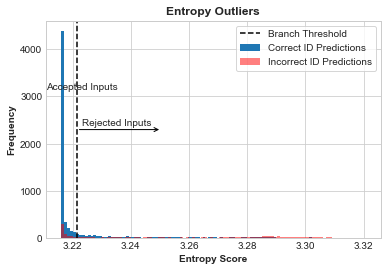

['exit_1']


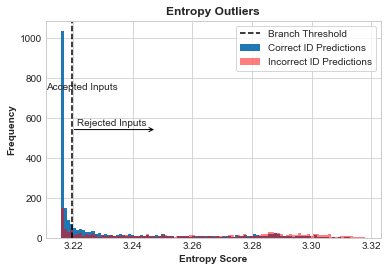

['exit_1', 'exit_2']


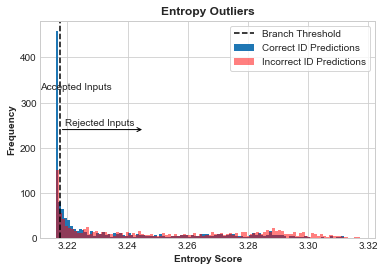

main_exit
   Exit_Name  ID_Inputs  Test_Accuracy Threshold  Accepted Input  Accepted_Correct  Accepted Accuracy  Rejected Input  Accepted %
0     exit_1      10000         0.7428  3.221658            5827              5281           0.906298        0.417300    0.582700
1     exit_2       4173         0.7802  3.219826            1581              1326           0.838710        0.621136    0.378864
2  Main_exit       2592         0.7775        NA            2592              1356           0.523148        0.000000    1.000000


In [31]:
#ADAM ES
EvaluateID(output_ID,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

metric:  entropy threshold:  gmean


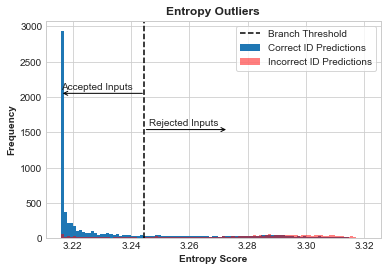

['exit_1']


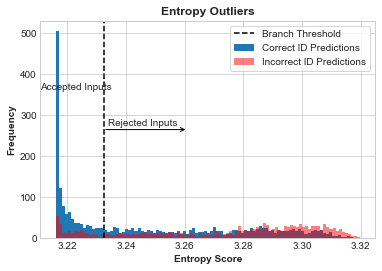

['exit_1', 'exit_2']


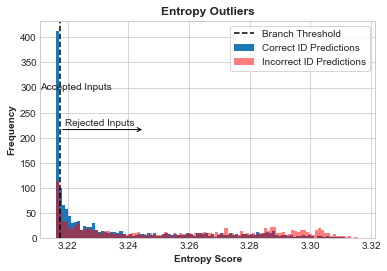

main_exit
   Exit_Name  ID_Inputs  Test_Accuracy Threshold  Accepted Input  Accepted_Correct  Accepted Accuracy  Rejected Input  Accepted %
0     exit_1      10000         0.7377  3.244596            5758              5263           0.914033        0.424200    0.575800
1     exit_2       4242         0.7704  3.232446            1438              1171           0.814325        0.661009    0.338991
2  Main_exit       2804         0.7855        NA            2804              1512           0.539230        0.000000    1.000000


In [23]:
#SGD ES
EvaluateID(output_ID,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

metric:  entropy threshold:  gmean
(0.0, 3373.65) 3373.65
(3.2108311653137207, 3.325166225433349) 2.9093132495880125


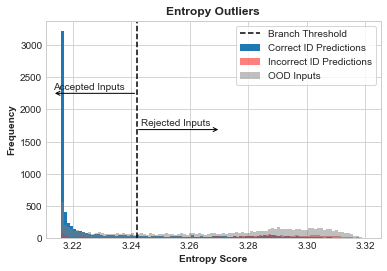

['exit_1']
(0.0, 683.55) 683.55
(3.2108405470848083, 3.324969208240509) 2.8929640853405


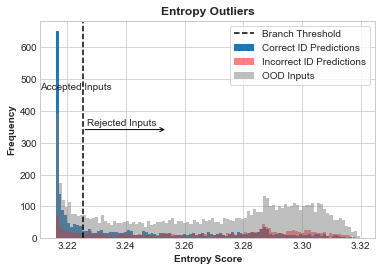

['exit_1', 'exit_2']
(0.0, 980.7) 980.7
(3.210911774635315, 3.3234734296798707) 2.8848443531990053


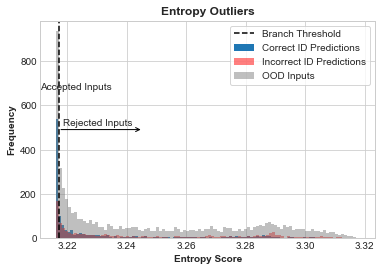

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7328   3.24183         5999          2785              5388           0.682946             0.613388
1     exit_2       4001        7215         0.7770  3.225461         1397          1195              1164           0.538966             0.449074
2  Main_exit       2604        6020         0.7898        NA         2604          6020              1404           0.301948             0.162801


In [22]:
EvaluateOOD(output_ID,output_OOD,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])